## Imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
from skimage import io
import nba_api
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from nba_api.stats.static import teams, players
from nba_api.stats.library.parameters import SeasonAll
from nba_api.stats.endpoints import playergamelog, teamgamelog, teamdashlineups, leaguelineupviz
from nba_api.stats.endpoints.synergyplaytypes import LeagueID
from nba_api.stats.endpoints.shotchartlineupdetail import ConferenceNullable
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.library.parameters import Season
from nba_api.stats.library.parameters import SeasonType

from nba_api.stats.endpoints import commonplayerinfo, shotchartdetail, boxscoreadvancedv3, playbyplay
import pprint
pp = pprint.PrettyPrinter(indent=4)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import plotly.graph_objects as go
from plotly.subplots import make_subplots



C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Create dictionaries and helper functions

In [9]:
# Select the dictionary for the Pacers, which contains their team ID
player_dict = players.get_players()
nba_teams = teams.get_teams()
player_info = pd.DataFrame.from_dict(player_dict)
team_info = pd.DataFrame.from_dict(nba_teams)
player_dict = player_info[['id','full_name']].set_index('full_name').to_dict()['id']
team_dict = team_info[['id','abbreviation']].set_index('abbreviation').to_dict()['id']
full_name_dict = team_info.set_index('abbreviation').to_dict()['full_name']
full_name_dict['NOH'] = 'New Orleans Pelicans'

2544

## Lineup Ideas: Find best lineups, determine best lineups for individual players

### Create Lineup DataFrame + Helper Function

In [3]:
def reorder_lineup(x):
    return '-'.join(sorted([a for a in x.split('-') if a.strip()]))

In [10]:
# '2014-15','2015-16','2016-17','2017-18','2018-19','2021-22','2022-23'
seasons = ['2019-20','2020-21','2022-23', '2023-24']
season_type = 'Regular Season'
url = "https://api.pbpstats.com/get-lineup-player-stats/nba"
all_lineups_list = []
team = 'LAL'
lineup_size = 5
team_id = team_dict[team]
key_player = 'LeBron James'
star_player = 'Anthony Davis'
minimum_mins_played = 5

for season in seasons:
   warriors_lineup_df = teamdashlineups.TeamDashLineups(team_id=team_id,group_quantity=lineup_size,season=season,
                                                        season_type_all_star=season_type)\
            .get_data_frames()[1][['GROUP_SET', 'GROUP_ID', 'GROUP_NAME', 'MIN',
         'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK']]
   
   lineups = list(set(warriors_lineup_df['GROUP_ID']))
   
   for lineup in lineups:
      params = {
         "LineupId": reorder_lineup(lineup), # lineup ids are hyphen separated player ids sorted as strings
         "Season": season,
         "SeasonType": season_type
      }
      response = requests.get(url, params=params)
      response_json = response.json()
      lineup_stats = response_json['single_row_table_data']
      if 'FG3M' not in lineup_stats.keys():
         lineup_stats['FG3M'] = 0
      if 'FG2M' not in lineup_stats.keys():
         lineup_stats['FG2M'] = 0
      if 'FG3A' not in lineup_stats.keys():
         lineup_stats['FG3A'] = 0
         lineup_stats['FG3M'] = 0
      if 'FG2A' not in lineup_stats.keys():
         lineup_stats['FG2M'] = 0
         lineup_stats['FG2A'] = 0
      if 'FTA' not in lineup_stats.keys():
         lineup_stats['FTA'] = 0
         lineup_stats['FTM'] = 0
      if 'FTM' not in lineup_stats.keys():
         lineup_stats['FTM'] = 0
      if 'OpponentPoints' not in lineup_stats.keys():
         lineup_stats['OpponentPoints'] = 0
      if 'Points' not in lineup_stats.keys():
         lineup_stats['Points'] = 0
         lineup_stats['TsPct'] = 0.0
      if 'ShortName' not in lineup_stats.keys():
          continue
      elif 'Minutes' not in lineup_stats.keys():
          continue
      elif 'DefPoss' not in lineup_stats.keys():
          continue
      elif 'OffPoss' not in lineup_stats.keys():
          continue
      else:
         lineup_df = pd.DataFrame([lineup_stats])[["Name", 'OffPoss', 'DefPoss', "Minutes", 'Points', 'OpponentPoints', 'FG2M', 'FG2A', 'FG3M', 'FG3A', 'TsPct','FTA']]
         lineup_df = lineup_df.rename(columns={'Name':'Lineup','Points':'Team Points','FG2M': 'Team FG2M', 'FG2A':'Team FG2A', 'FG3M':'Team FG3M', 'FG3A':'Team FG3A', 'TsPct':'Team TsPct','FTA':'Team FTA'})
         lineup_df['Season'] = season
         lineup_df['Team'] = team
         player_stats = response_json['multi_row_table_data']
         for player_stat in player_stats:
            if not set(['Points','TsPct']).issubset(player_stat.keys()):
                  player_stat['Points'] = 0
                  player_stat['TsPct'] = 0.0
            if 'FG3A' not in player_stat.keys():
               player_stat['FG3A'] = 0
               player_stat['FG3M'] = 0
            if 'FG2A' not in player_stat.keys():
               player_stat['FG2M'] = 0
               player_stat['FG2A'] = 0
            if 'FTA' not in player_stat.keys():
               player_stat['FTA'] = 0
            if 'OpponentPoints' not in player_stat.keys():
                  player_stat['OpponentPoints'] = 0
            if 'Minutes' not in player_stat.keys():
               player_stat['Minutes'] = 0
            if 'OffPoss' not in player_stat.keys():
                  player_stat['OffPoss'] = 0
            if 'DefPoss' not in player_stat.keys():
                  player_stat['DefPoss'] = 0
            player_df = pd.DataFrame([player_stat])[['Name', 'EntityId', 'Minutes', 'OffPoss', 'DefPoss', 'Points', 'OpponentPoints', 'TsPct','FG2A','FG3A','FTA']]
            all_lineups_list.append(player_df.merge(lineup_df,on=['Minutes','OffPoss','DefPoss','OpponentPoints']))

In [11]:
all_lineups_df = pd.concat(all_lineups_list).reset_index(drop=True)
all_lineups_df['PtsPer75'] = all_lineups_df['Points'] * 75 / all_lineups_df['OffPoss']
all_lineups_df['FGA'] = all_lineups_df['FG2A'] + all_lineups_df['FG3A']
all_lineups_df['Team FGA'] = all_lineups_df['Team FG2A'] + all_lineups_df['Team FG3A']
all_lineups_df[['Lineup','Minutes','Season']].sort_values(by='Minutes',ascending=False)
all_lineups_df.to_csv(f'{team}_{key_player}_{star_player}_{season_type}.csv')

### Track Player Production in Same Lineup across multiple years

In [102]:

all_lineups_df_comb = all_lineups_df[['Lineup','OffPoss','Minutes','Points','FGA','FTA']].groupby('Lineup').sum().reset_index().sort_values(by='Minutes')
all_lineups_df_comb[star_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if star_player in x else 0)
all_lineups_df_comb[role_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if role_player in x else 0)
no_stars_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 0)&(all_lineups_df_comb[role_player] == 0)][['OffPoss','Minutes','Points','FGA','FTA']]
two_legends_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 1)&(all_lineups_df_comb[role_player] == 0)][['OffPoss','Minutes','Points','FGA','FTA']]
two_shooters_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 0)&(all_lineups_df_comb[role_player] == 1)][['OffPoss','Minutes','Points','FGA','FTA']]
everyone_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 1)&(all_lineups_df_comb[role_player] == 1)][['OffPoss','Minutes','Points','FGA','FTA']]
ns_mins = np.sum(no_stars_df)['Minutes']
jk_mins = np.sum(two_shooters_df)['Minutes']
js_mins = np.sum(two_legends_df['Minutes'])
e_mins = np.sum(everyone_df['Minutes'])

print(f'Points Per 75 without {role_player} or {star_player} ({ns_mins} Minutes Played):')
print(round(np.sum(no_stars_df)['Points'] * 75/ np.sum(no_stars_df)['OffPoss'],2))
print("TS%:")
print(round(np.sum(no_stars_df)['Points'] * 100 / (2 * (np.sum(no_stars_df)['FGA'] + 0.44 * np.sum(no_stars_df)['FTA'])),2))
print('\n')
print(f'Points Per 75 with just {role_player} ({jk_mins} Minutes Played):')
print(round(np.sum(two_shooters_df)['Points'] * 75/ np.sum(two_shooters_df)['OffPoss'],2))
print("TS%:")
print(round(np.sum(two_shooters_df)['Points'] * 100 / (2 * (np.sum(two_shooters_df)['FGA'] + 0.44 * np.sum(two_shooters_df)['FTA'])),2))
print('\n')
print(f'Points Per 75 with just {star_player} ({js_mins} Minutes Played):')
print(round(np.sum(two_legends_df)['Points'] * 75/ np.sum(two_legends_df)['OffPoss'],2))
print("TS%:")
print(round(np.sum(two_legends_df)['Points'] * 100 / (2 * (np.sum(two_legends_df)['FGA'] + 0.44 * np.sum(two_legends_df)['FTA'])),2))
print('\n')
print(f'Points Per 75 with everyone ({e_mins} Minutes Played):')
print(round(np.sum(everyone_df)['Points'] * 75/ np.sum(everyone_df)['OffPoss'],2))
print("TS%:")
print(round(np.sum(everyone_df)['Points'] * 100 / (2 * (np.sum(everyone_df)['FGA'] + 0.44 * np.sum(everyone_df)['FTA'])), 2))
print('\n')

Points Per 75 without Green or Curry (460 Minutes Played):
22.12
TS%:
55.05


Points Per 75 with just Green (1022 Minutes Played):
24.55
TS%:
56.29


Points Per 75 with just Curry (492 Minutes Played):
18.14
TS%:
60.28


Points Per 75 with everyone (3092 Minutes Played):
18.66
TS%:
55.34




C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



### Player Production Lineups for the Same Year

In [15]:
all_lineups_df_comb = all_lineups_df[['Lineup','OffPoss','DefPoss','Minutes','Points','Team Points','OpponentPoints','FGA','FTA','Season','Name']]
all_lineups_df_comb[key_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if key_player in x else 0)
all_lineups_df_comb[star_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if star_player in x else 0)
#all_lineups_df_comb[role_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if role_player in x else 0)

no_stars_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 0)&(all_lineups_df_comb[key_player] == 0)][['OffPoss','Minutes','Points','FGA','FTA','Season']].groupby('Season').sum().reset_index()
no_stars_df['PtsPer75'] = round(no_stars_df['Points'] * 75/ no_stars_df['OffPoss'],2)
no_stars_df['TS%'] = round(no_stars_df['Points'] * 100 / (2 * no_stars_df['FGA'] + 0.44 * no_stars_df['FTA']),2)
no_stars_df['Designation'] = 'No Key Players'

one_star_df = all_lineups_df_comb[(all_lineups_df_comb[star_player]  + all_lineups_df_comb[key_player] == 1)][['OffPoss','Minutes','Points','FGA','FTA','Season','Name']].groupby(['Season','Name']).sum().reset_index()
one_star_df = one_star_df[one_star_df['Name'].isin([star_player,key_player])]
one_star_df['PtsPer75'] = round(one_star_df['Points'] * 75/ one_star_df['OffPoss'],2)
one_star_df['TS%'] = round(one_star_df['Points'] * 100 / (2 * one_star_df['FGA'] + 0.44 * one_star_df['FTA']),2)
one_star_df['Designation'] = 'One Star Player ' +  '(' + one_star_df['Name'].apply(lambda x: x.split()[-1]) + ')'

two_stars_df = all_lineups_df_comb[(all_lineups_df_comb[star_player]  + all_lineups_df_comb[key_player] == 2)][['OffPoss','Minutes','Points','FGA','FTA','Season','Name']].groupby(['Season','Name']).sum().reset_index()
two_stars_df = two_stars_df[two_stars_df['Name'].isin([star_player,key_player])]
two_stars_df['PtsPer75'] = round(two_stars_df['Points'] * 75/ two_stars_df['OffPoss'],2)
two_stars_df['TS%'] = round(two_stars_df['Points'] * 100 / (2 * two_stars_df['FGA'] + 0.44 * two_stars_df['FTA']),2)
two_stars_df['Designation'] = 'Both Stars ' + '(' + two_stars_df['Name'].apply(lambda x: x.split()[-1]) + ')'


comb_df = pd.concat([no_stars_df,one_star_df,two_stars_df]).reset_index(drop=True)

fig2 = px.line(comb_df, x = 'Season', y = 'PtsPer75',color = 'Designation',title=f'Production of {key_player} in Lineups',
        hover_data={'TS%':True, 'Minutes':True,'Designation':False,'Season':False})
fig2.show()


C:\Users\ynakadi\AppData\Local\Temp\ipykernel_24332\300793813.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ynakadi\AppData\Local\Temp\ipykernel_24332\300793813.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotly\express\_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a

NBA Podcast (Wharton Moneyball) Notes 
- Seth Stephens-Davidowitz: Who Makes the NBA?, Everybody Lies
- Idea: normalize for height
    - Each inch doubles your chances of joining the nba (7 footers have a 1/7 chance, general population)
- Idea: MJ is 9th best height-adjusted player
    - Muggsy Boges is #1 all time, Chris Paul is #1 among active players
- Idea: negative relation between height and athletic abilities/certain skills
    - Intuition: you don't have to be as good
- Idea: FT% as proxy for clutch shooting (clutch is <= 5 mins remaining in game)
    - Other shots tend to be low probability
    - Typically players' FT% decreased by 1%
    - Influenced primarily by height
- Is clutchness multidimensional or singular
- Coaching:
    - NBA Coaches make the biggest difference
    - Best ideas are in blogs
        - How good player was before playing for the coach compared to now
        - Also adjust for age
- Fixed effect model on how often player passes ball when driving to basket
- PLayers have incentive to solely score: great coaches get players to be more passive 

## Game by Game Data (Basic Team Stats, ORTG, think of other ideas)

In [ ]:
dfs = []
def get_opponent(stri):
  if '@' in stri:
    return full_name_dict[stri.replace(' ','').split('@')[1]]
  else:
    return full_name_dict[stri.replace(' ','').split('.')[1]]

def get_location(stri):
  if '@' in stri:
    return 'Road'
  else:
    return 'Home'
start_year = 2013
end_year = 2024
for season in [str(x) + '-' + str(x + 1)[2:] for x in range(start_year,end_year)]:
    print(season)
    east_games = leaguegamefinder.LeagueGameFinder(
                              league_id_nullable=LeagueID.nba,
                              vs_conference_nullable=ConferenceNullable.east,
                              season_nullable=season)

    west_games = leaguegamefinder.LeagueGameFinder(
                              league_id_nullable=LeagueID.nba,
                              vs_conference_nullable=ConferenceNullable.west,
                              season_nullable=season
                              )

    # Eastern Conference
    east_games_dict = east_games.get_normalized_dict()
    east_games = east_games_dict['LeagueGameFinderResults']
    east_games_df = pd.DataFrame.from_dict(east_games)
    east_games_df['Opponent Conference'] = 'East'
    
    # Western Conference
    west_games_dict = west_games.get_normalized_dict()
    west_games = west_games_dict['LeagueGameFinderResults']
    west_games_df = pd.DataFrame.from_dict(west_games)
    west_games_df['Opponent Conference'] = 'West'
    
    # Combine them
    comb_df = pd.concat([east_games_df, west_games_df]).reset_index(drop=True)
    
    # Extract Relevant Data
    comb_df['GAME_DATE'] = pd.to_datetime(comb_df['GAME_DATE'])
    comb_df['GAME_TYPE'] = comb_df['GAME_ID'].apply(lambda x: x[2])
    comb_df['SEASON'] = season
    #Filter out preseason, all-star games
    comb_df = comb_df[(comb_df['TEAM_ABBREVIATION'].isin(full_name_dict.keys())) & ((comb_df["GAME_TYPE"] != '1') & (comb_df['GAME_TYPE'] != '3'))]
    comb_df['PTS Allowed'] = comb_df['PTS'] - comb_df['PLUS_MINUS']
    comb_df['Opponent'] = comb_df['MATCHUP'].apply(lambda x: get_opponent(x))
    comb_df['Location'] = comb_df['MATCHUP'].apply(lambda x: get_location(x))
    dfs.append(comb_df)
game_by_game_df = pd.concat(dfs)
game_by_game_df['Win'] = game_by_game_df['WL'].apply(lambda x: 1 if x == 'W' else 0)

2013-14
2014-15
2015-16
2016-17
2017-18
2018-19
2019-20
2020-21
2021-22
2022-23
2023-24


In [ ]:
game_by_game_df.head(10)#.sort_values('GAME_DATE')

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,TOV,PF,PLUS_MINUS,Opponent Conference,GAME_TYPE,SEASON,PTS Allowed,Opponent,Location,Win
0,42013,1610612759,SAS,San Antonio Spurs,0041300405,2014-06-15,SAS vs. MIA,W,239,104,...,8,21,17.0,East,4,2013-14,87.0,Miami Heat,Home,1
1,42013,1610612759,SAS,San Antonio Spurs,0041300404,2014-06-12,SAS @ MIA,W,242,107,...,14,19,21.0,East,4,2013-14,86.0,Miami Heat,Road,1
2,42013,1610612759,SAS,San Antonio Spurs,0041300403,2014-06-10,SAS @ MIA,W,240,111,...,12,25,19.0,East,4,2013-14,92.0,Miami Heat,Road,1
3,42013,1610612759,SAS,San Antonio Spurs,0041300402,2014-06-08,SAS vs. MIA,L,240,96,...,11,20,-2.0,East,4,2013-14,98.0,Miami Heat,Home,0
4,42013,1610612759,SAS,San Antonio Spurs,0041300401,2014-06-05,SAS vs. MIA,W,240,110,...,22,14,15.0,East,4,2013-14,95.0,Miami Heat,Home,1
5,42013,1610612748,MIA,Miami Heat,0041300306,2014-05-30,MIA vs. IND,W,242,117,...,9,22,25.0,East,4,2013-14,92.0,Indiana Pacers,Home,1
6,42013,1610612754,IND,Indiana Pacers,0041300306,2014-05-30,IND @ MIA,L,241,92,...,11,17,-25.0,East,4,2013-14,117.0,Miami Heat,Road,0
7,42013,1610612754,IND,Indiana Pacers,0041300305,2014-05-28,IND vs. MIA,W,240,93,...,12,16,3.0,East,4,2013-14,90.0,Miami Heat,Home,1
8,42013,1610612748,MIA,Miami Heat,0041300305,2014-05-28,MIA @ IND,L,239,90,...,17,24,-3.0,East,4,2013-14,93.0,Indiana Pacers,Road,0
9,42013,1610612754,IND,Indiana Pacers,0041300304,2014-05-26,IND @ MIA,L,241,90,...,14,27,-12.0,East,4,2013-14,102.0,Miami Heat,Road,0


In [ ]:
game_by_game_df.to_csv('game_by_game.csv', index=False)

In [ ]:
game_by_game_df = pd.read_csv('game_by_game.csv',converters={'GAME_ID': str})

In [ ]:
game_by_game_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,TOV,PF,PLUS_MINUS,Opponent Conference,GAME_TYPE,SEASON,PTS Allowed,Opponent,Location,Win
0,42013,1610612759,SAS,San Antonio Spurs,0041300405,2014-06-15,SAS vs. MIA,W,239,104,...,8,21,17.0,East,4,2013-14,87.0,Miami Heat,Home,1
1,42013,1610612759,SAS,San Antonio Spurs,0041300404,2014-06-12,SAS @ MIA,W,242,107,...,14,19,21.0,East,4,2013-14,86.0,Miami Heat,Road,1
2,42013,1610612759,SAS,San Antonio Spurs,0041300403,2014-06-10,SAS @ MIA,W,240,111,...,12,25,19.0,East,4,2013-14,92.0,Miami Heat,Road,1
3,42013,1610612759,SAS,San Antonio Spurs,0041300402,2014-06-08,SAS vs. MIA,L,240,96,...,11,20,-2.0,East,4,2013-14,98.0,Miami Heat,Home,0
4,42013,1610612759,SAS,San Antonio Spurs,0041300401,2014-06-05,SAS vs. MIA,W,240,110,...,22,14,15.0,East,4,2013-14,95.0,Miami Heat,Home,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27733,22023,1610612759,SAS,San Antonio Spurs,0022300073,2023-10-25,SAS vs. DAL,L,240,119,...,19,23,-7.0,West,2,2023-24,126.0,Dallas Mavericks,Home,0
27734,22023,1610612743,DEN,Denver Nuggets,0022300061,2023-10-24,DEN vs. LAL,W,240,119,...,11,15,12.0,West,2,2023-24,107.0,Los Angeles Lakers,Home,1
27735,22023,1610612747,LAL,Los Angeles Lakers,0022300061,2023-10-24,LAL @ DEN,L,239,107,...,11,18,-12.0,West,2,2023-24,119.0,Denver Nuggets,Road,0
27736,22023,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24,PHX @ GSW,W,241,108,...,19,22,4.0,West,2,2023-24,104.0,Golden State Warriors,Road,1


In [ ]:
off_rating_df = game_by_game_df[['SEASON','GAME_DATE','GAME_ID','GAME_TYPE','TEAM_ABBREVIATION','PTS','TOV','FGA','FGM','FTA','OREB','DREB']]

team1_df = off_rating_df.sort_values(by='GAME_ID').reset_index(drop=True).iloc[::2]#[['GAME_ID','TEAM_ABBREVIATION','PTS','TOV','FGA','FGM','FTA','OREB','DREB']]
team2_df = off_rating_df.sort_values(by='GAME_ID').reset_index(drop=True).iloc[1::2]

comb1_df = team1_df.merge(team2_df.rename(columns={'TEAM_ABBREVIATION':'OPP TEAM_ABBREVIATION','PTS':'OPP PTS','TOV':'OPP TOV','FGA':'OPP FGA','FGM':'OPP FGM','FTA':'OPP FTA','OREB':'OPP OREB','DREB':'OPP DREB'}), on = 'GAME_ID')
comb2_df = team2_df.merge(team1_df.rename(columns={'TEAM_ABBREVIATION':'OPP TEAM_ABBREVIATION','PTS':'OPP PTS','TOV':'OPP TOV','FGA':'OPP FGA','FGM':'OPP FGM','FTA':'OPP FTA','OREB':'OPP OREB','DREB':'OPP DREB'}), on = 'GAME_ID')
new_stats_df = pd.concat([comb1_df,comb2_df]).sort_values(by='GAME_ID')
new_stats_df = new_stats_df.drop(['SEASON_y','GAME_DATE_y','GAME_TYPE_y'],axis=1)
new_stats_df = new_stats_df.rename(columns = {'SEASON_x' : 'SEASON', 'GAME_DATE_x' : 'GAME_DATE','GAME_TYPE_x':'GAME_TYPE'})

In [ ]:
# Pt 1: (Tm FGA + 0.4 * Tm FTA - 1.07 * (Tm ORB / (Tm ORB + Opp DRB)) * (Tm FGA - Tm FG) + Tm TOV)
# Pt 2: (Opp FGA + 0.4 * Opp FTA - 1.07 * (Opp ORB / (Opp ORB + Tm DRB)) * (Opp FGA - Opp FG) + Opp TOV)
def calc_possessions(row):
    pt1 = (row['FGA'] + 0.4 * row['FTA'] - 1.07 * (row['OREB'] / (row['OREB'] + row['OPP DREB'])) * (row['FGA'] - row['FGM']) + row['TOV'])
    pt2 = (row['OPP FGA'] + 0.4 * row['OPP FTA'] - 1.07 * (row['OPP OREB'] / (row['OPP OREB'] + row['DREB'])) * (row['OPP FGA'] - row['OPP FGM']) + row['OPP TOV'])
    return (pt1 + pt2) * 0.5

def calc_offrating(row):
    pt1 = (row['FGA'] + 0.4 * row['FTA'] - 1.07 * (row['OREB'] / (row['OREB'] + row['OPP DREB'])) * (row['FGA'] - row['FGM']) + row['TOV'])
    pt2 = (row['OPP FGA'] + 0.4 * row['OPP FTA'] - 1.07 * (row['OPP OREB'] / (row['OPP OREB'] + row['DREB'])) * (row['OPP FGA'] - row['OPP FGM']) + row['OPP TOV'])
    return round(row['PTS'] * 200 / (pt1 + pt2),1)

def calc_defrating(row):
    pt1 = (row['FGA'] + 0.4 * row['FTA'] - 1.07 * (row['OREB'] / (row['OREB'] + row['OPP DREB'])) * (row['FGA'] - row['FGM']) + row['TOV'])
    pt2 = (row['OPP FGA'] + 0.4 * row['OPP FTA'] - 1.07 * (row['OPP OREB'] / (row['OPP OREB'] + row['DREB'])) * (row['OPP FGA'] - row['OPP FGM']) + row['OPP TOV'])
    return row['OPP PTS'] * 200 / (pt1 + pt2)

new_stats_df['NUM POSSESSIONS'] = new_stats_df.apply(lambda row: calc_possessions(row), axis = 1)
new_stats_df['OFF RATING'] = 100 * new_stats_df['PTS'] / new_stats_df['NUM POSSESSIONS']
new_stats_df['DEF RATING'] = 100 * new_stats_df['OPP PTS'] / new_stats_df['NUM POSSESSIONS']
new_stats_df['NET RATING'] = new_stats_df['OFF RATING'] - new_stats_df['DEF RATING']

In [ ]:
new_stats_df[(new_stats_df['GAME_TYPE']==4)&(new_stats_df['GAME_DATE']<'2023-01-01')&(new_stats_df['TEAM_ABBREVIATION']=='MIN')]

,SEASON,GAME_DATE,GAME_ID,GAME_TYPE,TEAM_ABBREVIATION,PTS,TOV,FGA,FGM,FTA,...,OPP TOV,OPP FGA,OPP FGM,OPP FTA,OPP OREB,OPP DREB,NUM POSSESSIONS,OFF RATING,DEF RATING,NET RATING
13371,2017-18,2018-04-15,0041700141,4,MIN,101,13,80,35,28,...,11,83,39,23,8,29,92.799375,108.836940,112.069720,-3.232780
13372,2017-18,2018-04-18,0041700142,4,MIN,82,16,80,31,21,...,9,96,35,21,12,42,97.153460,84.402553,104.988541,-20.585988
13373,2017-18,2018-04-21,0041700143,4,MIN,121,7,90,45,22,...,10,81,37,25,7,32,94.465500,128.089091,111.151690,16.937400
13374,2017-18,2018-04-23,0041700144,4,MIN,100,16,84,39,23,...,6,92,40,26,10,36,97.770471,102.280371,121.713641,-19.433270
13375,2017-18,2018-04-25,0041700145,4,MIN,104,8,79,40,20,...,4,88,45,19,8,32,89.991625,115.566310,135.568171,-20.001861
13704,2021-22,2022-04-16,0042100151,4,MIN,130,18,90,45,27,...,12,86,39,43,8,27,105.352782,123.394939,111.055445,12.339494
13705,2021-22,2022-04-19,0042100152,4,MIN,96,19,76,30,28,...,9,92,44,32,14,34,100.219074,95.790149,123.728942,-27.938793
13706,2021-22,2022-04-21,0042100153,4,MIN,95,16,85,33,23,...,18,83,35,31,13,35,98.690879,96.260162,105.379546,-9.119384
13707,2021-22,2022-04-23,0042100154,4,MIN,119,15,74,35,40,...,17,86,42,25,6,33,101.635882,117.084633,116.100729,0.983904
13708,2021-22,2022-04-26,0042100155,4,MIN,109,22,83,37,24,...,16,94,39,39,18,35,106.690203,102.164957,104.039543,-1.874586


In [ ]:
new_stats_reg_df = new_stats_df[new_stats_df['GAME_TYPE'] == 2][['SEASON','TEAM_ABBREVIATION','PTS','OPP PTS','NUM POSSESSIONS']]
new_stats_reg_df['TEAM'] = new_stats_reg_df['TEAM_ABBREVIATION'] + ' ' + new_stats_reg_df['SEASON']
season_stats_df = new_stats_reg_df[['TEAM','PTS','OPP PTS','NUM POSSESSIONS']].groupby('TEAM').sum()
season_stats_df['OFF RATING'] = round(100 * season_stats_df['PTS'] / season_stats_df['NUM POSSESSIONS'],1)
season_stats_df['DEF RATING'] = round(100 * season_stats_df['OPP PTS'] / season_stats_df['NUM POSSESSIONS'],1)
season_stats_df['NET RATING'] = season_stats_df['OFF RATING'] - season_stats_df['DEF RATING']
season_stats_df.sort_values(by='OFF RATING').tail(20)

,PTS,OPP PTS,NUM POSSESSIONS,OFF RATING,DEF RATING,NET RATING
TEAM,,,,,,
DEN 2022-23,9495,9222,8024.116694,118.3,114.9,3.4
POR 2020-21,8360,8231,7068.430953,118.3,116.4,1.9
LAC 2020-21,8209,7764,6934.288319,118.4,112.0,6.4
UTA 2020-21,8382,7716,7081.034552,118.4,109.0,9.4
GSW 2023-24,8063,7941,6794.982815,118.7,116.9,1.8
ATL 2023-24,8095,8232,6822.229274,118.7,120.7,-2.0
NOP 2023-24,7886,7528,6637.716895,118.8,113.4,5.4
PHX 2023-24,8067,7893,6791.678227,118.8,116.2,2.6
BOS 2022-23,9671,9136,8141.908019,118.8,112.2,6.6


In [ ]:
new_stats_reg_df = new_stats_df[new_stats_df['GAME_TYPE'] == 4][['SEASON','TEAM_ABBREVIATION','OFF RATING','DEF RATING','NET RATING']]
new_stats_reg_df['TEAM'] = new_stats_reg_df['TEAM_ABBREVIATION'] + ' ' + new_stats_reg_df['SEASON']
season_stats_df = new_stats_reg_df[['TEAM','OFF RATING','DEF RATING','NET RATING']].groupby('TEAM').mean().round(1)

season_stats_df.sort_values(by = 'OFF RATING',ascending=False).head(20)

,OFF RATING,DEF RATING,NET RATING
TEAM,,,
UTA 2019-20,123.4,119.2,4.2
UTA 2020-21,122.6,123.9,-1.3
POR 2020-21,122.2,123.2,-1.0
LAC 2020-21,121.6,117.2,4.4
CLE 2016-17,120.9,112.5,8.4
DEN 2022-23,120.3,111.5,8.8
GSW 2016-17,119.3,106.0,13.4
NOP 2021-22,118.5,120.1,-1.6
BOS 2022-23,118.2,114.6,3.6


In [ ]:
# Regular Season Games
reg_games = game_by_game_df[game_by_game_df['GAME_TYPE'] == 2]
game_by_game_df['Team'] = game_by_game_df['TEAM_ABBREVIATION'] + ' ' + game_by_game_df['SEASON']

wins = game_by_game_df[['TEAM_ABBREVIATION','Win','SEASON','GAME_TYPE']].groupby(by=['TEAM_ABBREVIATION','SEASON','GAME_TYPE']).count().reset_index()

# Playoff Games
playoff_teams = game_by_game_df[game_by_game_df['GAME_TYPE'] >= 4]['Team']
post_games = game_by_game_df[game_by_game_df['GAME_TYPE'] >= 4]

graph_df = post_games[['TEAM_ABBREVIATION','PLUS_MINUS','SEASON','Win']].groupby(by=['TEAM_ABBREVIATION','SEASON']).agg(Wins=('Win', np.sum),Plus_Minus =('PLUS_MINUS', np.mean)).reset_index()
graph_df['Team'] = graph_df['TEAM_ABBREVIATION'] + ' ' + graph_df['SEASON']
graph_df = graph_df.sort_values(by='Wins',ascending=True)

fig = px.scatter(graph_df[graph_df['Team'].isin(playoff_teams)], x = 'Wins', y = 'Plus_Minus', color = 'TEAM_ABBREVIATION', text="Team")
fig.update_traces(textposition='top center')
fig.show()

graph2_df = post_games[['TEAM_ABBREVIATION','PTS','SEASON','PTS Allowed']].groupby(by=['TEAM_ABBREVIATION','SEASON']).mean().reset_index()
graph2_df['Team'] = graph2_df['TEAM_ABBREVIATION'] + ' ' + graph2_df['SEASON']
fig2 = px.scatter(graph2_df[graph2_df['Team'].isin(playoff_teams)], x = 'PTS', y = 'PTS Allowed', color = 'TEAM_ABBREVIATION', text="Team")
fig2.update_traces(textposition='top center')
fig2['layout']['yaxis']['autorange'] = "reversed"
fig2.show()


C:\Users\ynakadi\AppData\Local\Temp\ipykernel_15088\2916166130.py:11: FutureWarning:

The provided callable <function sum at 0x0000021846AAC700> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.

C:\Users\ynakadi\AppData\Local\Temp\ipykernel_15088\2916166130.py:11: FutureWarning:

The provided callable <function mean at 0x0000021846AAD630> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotly\express\_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warni

C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotly\express\_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



## Shot Chart Detail Ideas

In [ ]:


bucks_df = game_by_game_df[(game_by_game_df['TEAM_ABBREVIATION'] == 'MIL')&(game_by_game_df['SEASON']=='2022-23')]

player_details = [player for player in player_dict if player['full_name'] == 'Giannis Antetokounmpo'][0]


player_num = player_details['id']
print(player_num)

player_info = commonplayerinfo.CommonPlayerInfo(player_id=203507)
player_stats = player_info.player_headline_stats.get_dict()
print(player_stats)


pd.options.display.max_seq_items = 100
shot_chart = shotchartdetail.ShotChartDetail(
player_id = 0,
season_nullable='2021-22',
season_type_all_star='Regular Season',
team_id=1610612749,
context_measure_simple='FGA',)


print(shot_chart.get_available_data())
shot_df = shot_chart.shot_chart_detail.get_data_frame()

# Get specific player shot chart
player_made_df = shot_df[(shot_df['SHOT_MADE_FLAG']==1) & (shot_df['PLAYER_ID']==player_num)]
player_missed_df = shot_df[(shot_df['SHOT_MADE_FLAG']==0) & (shot_df['PLAYER_ID']==player_num)]

# Get rest of team shot chart
rest_of_team_made_df = shot_df[(shot_df['SHOT_MADE_FLAG']==1) & (shot_df['PLAYER_ID']!=player_num)]
rest_of_team_missed_df = shot_df[(shot_df['SHOT_MADE_FLAG']==0) & (shot_df['PLAYER_ID']!=player_num)]
giannis_df = shot_df[(shot_df['PLAYER_ID']==player_num)]

bucks_games = pd.concat([boxscoreadvancedv2.BoxScoreAdvancedV2(game_id = game).get_data_frames()[0] for game in set(bucks_df['GAME_ID'])])
#bucks_games_pbp = pd.concat([playbyplay.PlayByPlay(game).get_data_frames()[0] for game in set(bucks_df['GAME_ID'])])
giannis_games = bucks_games[bucks_games['NICKNAME'] == 'Giannis']

TypeError: string indices must be integers

## PBP Data (Lead Volatility Idea)

In [ ]:
game_season_dict = game_by_game_df[['SEASON','GAME_ID']].set_index('GAME_ID').to_dict()['SEASON']
game_season_dict
games = list(set(game_by_game_df['GAME_ID']))
big_lead = 20
small_deficit = 0
main_df = []
num_so_far = 383
shuffle = 100
count = 0
for game in games[num_so_far:num_so_far+shuffle]:
    df = pd.DataFrame()
    pbp_df = playbyplay.PlayByPlay(game).get_data_frames()[0][['SCOREMARGIN','GAME_ID']]
    count += 1
    if count % 5  == 0:
        print(count)
    pbp_df = pbp_df[(pbp_df['SCOREMARGIN'].notnull())]
    pbp_df['SCOREMARGIN'] = pbp_df['SCOREMARGIN'].replace("TIE","0").apply(lambda x: int(x))
    main_df.append(pbp_df)


# First 610

ReadTimeout: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)

In [ ]:
x_df = pd.concat([x_df,pd.concat(main_df)])#[['Season','Blown Leads']].groupby('Season').agg({'Blown Leads':['sum','count']})

In [ ]:
x_df.to_csv('x_df.csv', index=False)

In [ ]:
x_df = pd.read_csv('x_df.csv', converters={'GAME_ID':str})
len(set(x_df['GAME_ID']))

383

In [ ]:
x_df['new_game'] = x_df['GAME_ID'] != x_df.shift(1)['GAME_ID']
x_df['state'] = x_df.apply(lambda x: 'bl' if np.abs(x.SCOREMARGIN) >= big_lead else \
                           ('sl' if np.abs(x.SCOREMARGIN) <= small_deficit else \
                            ('ng' if x.new_game else None)),axis=1)
x_df = x_df[['SCOREMARGIN','state','GAME_ID','new_game']].dropna().reset_index(drop=True)
x_df['check'] = x_df['state'] + x_df.shift(1)['state'] 
x_df[x_df['check']=='slbl']['GAME_ID']

68      0042000222
653     0021300185
1774    0021900696
2195    0021400118
2885    0021301165
3044    0021700720
3471    0021601170
3658    0022200480
4092    0021700743
4168    0022300422
4196    0021900026
4770    0022300360
4866    0021300924
6435    0022100106
6516    0022300893
6709    0022000437
Name: GAME_ID, dtype: object

## Data Visualization Ideas

In [ ]:
image_df = pd.read_csv("NBAIMAGES.csv")
image_df["Team"] = image_df['Team'].apply(lambda x: full_name_dict[x])
#image_df

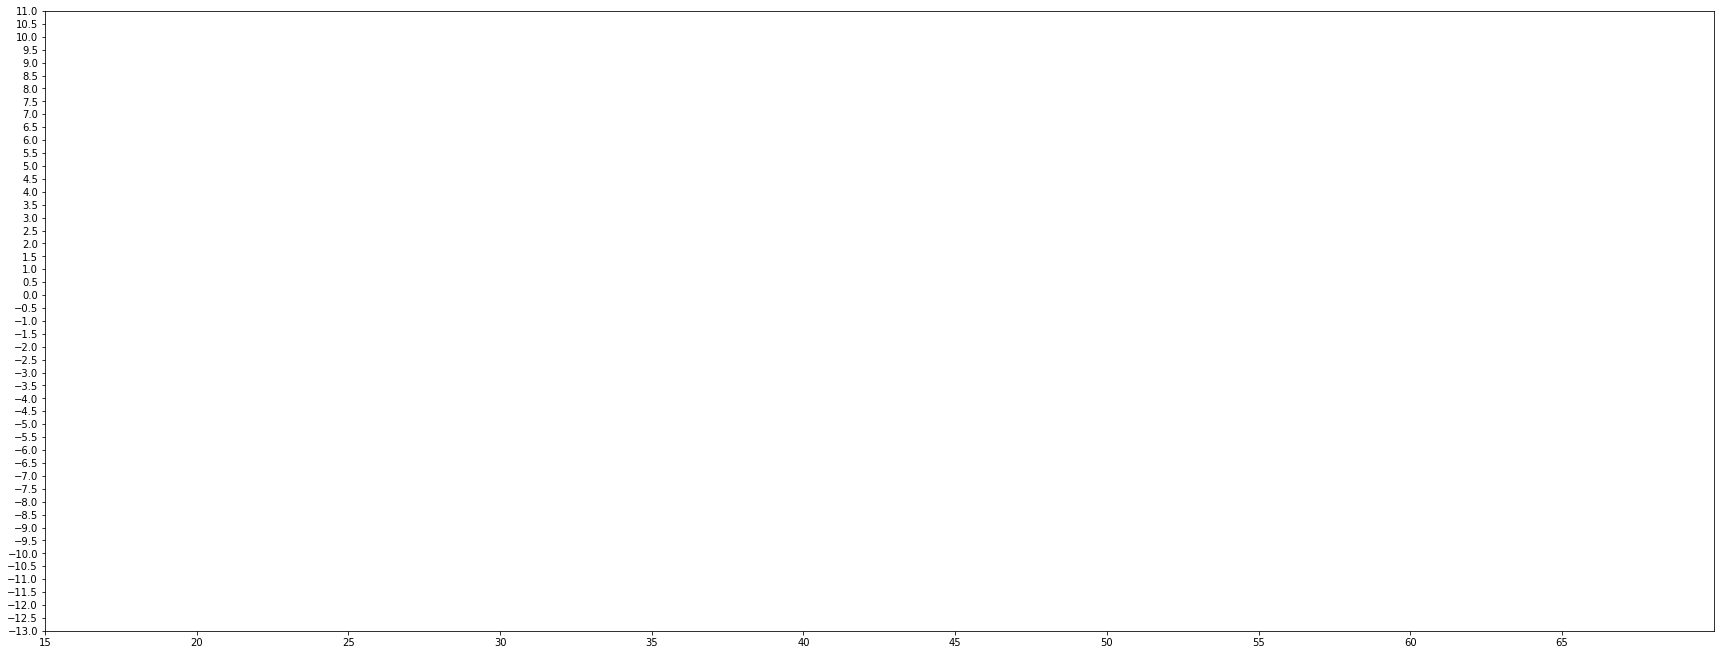

In [ ]:
scale = 0.8
x_shift = -.7 * scale
y_shift = -.8 * scale
image_shift = 500.0
zoom_shift = 0.06 * scale
length = 30.00 * scale
width = 11.50 * scale

plt.rcParams["figure.figsize"] = [length, width]
plt.rcParams["figure.autolayout"] = True

def getImage(path,alpha):
    img = io.imread(path)
    img = resize(img, (img.shape[0] * image_shift / img.shape[0],img.shape[1] *  image_shift / img.shape[1], 4),
                       anti_aliasing=True)
    return OffsetImage(img, zoom=zoom_shift,alpha=alpha)


graph2_df = graph_df.merge(image_df,  on= "Team").sample(frac=0.1)
x = [i for i in list(graph2_df['Wins'])]
y = [i for i in list(graph2_df['Plus_Minus'])]
z = [i for i in list(graph2_df["SEASON"])]
paths = list(graph2_df['Image Link'])

# Create Graph and Put Images in Place

fig, ax = plt.subplots()
for x0, y0, z0, path in zip(x, y, z, paths):
    alpha_val = 0.9
    ab = AnnotationBbox(getImage(path,alpha_val), (x0, y0), frameon=False)
    ax.annotate(z0, xy=(x0+x_shift,y0+y_shift))
    ax.add_artist(ab)

# X and Y Ticks on graph
plt.xticks(np.arange(0, 70, step=5))
plt.yticks(np.arange(-15, 15, step=0.5))
plt.xlim([15, 70])
plt.ylim([-13, 11])
fig = px.scatter(graph2_df, x = 'Wins', y = 'Plus_Minus', color = 'TEAM_ABBREVIATION', hover_name = "Team", text="SEASON")
fig.show()
# plt.show()